# Decision Tree Model

In [1]:
# Initial imports
import pandas as pd
from path import Path
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import psycopg2
import pandas as pd
import numpy as np
from pathlib import Path
from collections import Counter
from path import Path

from pandas import DataFrame
import seaborn as sns
%matplotlib inline

from imblearn.over_sampling import SMOTE

# Import password
from config import password

# Connect to Database

In [2]:
#Connect to PgAdmin
engine = psycopg2.connect(
    database="project-data",
    user = "postgres",
    password = password,
    host = "happinessproject.cqkpnj5dcmou.us-east-1.rds.amazonaws.com",
    port = '5432'
    )

cursor = engine.cursor()

In [3]:
#Pull combined data table
query = "SELECT * from combined_data"

df = pd.read_sql(query, con=engine)
df.head()

,country_name,region,ladder_score,stand_err,up_whisker,low_whisker,log_gdp_per_cap,social_support,healty_life_exp,freedom,...,ladder_2011,ladder_2012,ladder_2013,ladder_2014,ladder_2015,ladder_2016,ladder_2017,ladder_2018,ladder_2019,ladder_2020
0,Afghanistan,South Asia,2.523,0.038,2.596,2.449,7.695,0.463,52.493,0.382,...,3.832,3.783,3.572,3.131,3.983,4.220,2.662,2.694,2.375,NaN
1,Albania,Central and Eastern Europe,5.117,0.059,5.234,5.001,9.520,0.697,68.999,0.785,...,5.867,5.510,4.551,4.814,4.607,4.511,4.640,5.004,4.995,5.365
2,Algeria,Middle East and North Africa,4.887,0.053,4.991,4.783,9.342,0.802,66.005,0.480,...,5.317,5.605,NaN,6.355,NaN,5.341,5.249,5.043,4.745,NaN
3,Argentina,Latin America and Caribbean,5.929,0.056,6.040,5.819,9.962,0.898,69.000,0.828,...,6.776,6.468,6.582,6.671,6.697,6.427,6.039,5.793,6.086,5.901
4,Armenia,Commonwealth of Independent States,5.283,0.058,5.397,5.168,9.487,0.799,67.055,0.825,...,4.260,4.320,4.277,4.453,4.348,4.325,4.288,5.062,5.488,NaN


# Prep Data for Machine Learning

In [4]:
#Create new df that contains only top 12 variables
df2 = df.filter(['ladder_score', 'healty_life_exp', 'covid_tests_per_mil', 'freedom', 'social_support', 'percept_corrupt', 'log_gdp_per_cap', 'covid_total_tests', 'meat_consumption', 'median_age', 'generosity', 'land_area_skm', 'covid_cases_per_mil'], axis=1)

In [5]:
#Drop all NA rows and view NA count as well as new df length
def dropNA(): 
    global df2
    mod_df = df2.dropna( )
    df2 = mod_df.dropna()
    df2 = pd.DataFrame(df2)


   
    # view total null values for columns
    print("Total NA count column")
    print(df2.isna().sum())
    #view length of df
    print ("")
    print(f"Length of Dataset is {len(df2)}")

In [6]:
dropNA()

Total NA count column
ladder_score           0
healty_life_exp        0
covid_tests_per_mil    0
freedom                0
social_support         0
percept_corrupt        0
log_gdp_per_cap        0
covid_total_tests      0
meat_consumption       0
median_age             0
generosity             0
land_area_skm          0
covid_cases_per_mil    0
dtype: int64

Length of Dataset is 125


# SMOTE Resolve Undersampling Imbalance (resource: https://www.kaggle.com/code/rafjaa/dealing-with-very-small-datasets/notebook)

In [7]:
df2

,ladder_score,healty_life_exp,covid_tests_per_mil,freedom,social_support,percept_corrupt,log_gdp_per_cap,covid_total_tests,meat_consumption,median_age,generosity,land_area_skm,covid_cases_per_mil
0,2.523,52.493,2317.0,0.382,0.463,0.924,7.695,90396.0,17.3,27.4,-0.102,652230.0,946.0
3,5.929,69.000,17564.0,0.828,0.898,0.834,9.962,794544.0,79.7,31.7,-0.182,2780400.0,5044.0
4,5.283,67.055,57898.0,0.825,0.799,0.629,9.487,171600.0,27.7,35.1,-0.168,29743.0,13435.0
5,7.183,73.900,181419.0,0.914,0.940,0.442,10.796,4631419.0,108.2,38.7,0.159,7741220.0,779.0
6,7.268,73.300,104008.0,0.908,0.934,0.481,10.906,937275.0,94.1,44.0,0.042,83871.0,2408.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,4.892,66.700,55138.0,0.615,0.861,0.827,9.073,1567431.0,56.6,28.3,-0.169,912050.0,784.0
145,5.411,68.034,4952.0,0.940,0.850,0.796,8.973,482456.0,28.6,30.5,-0.098,331210.0,8.0
146,3.658,57.122,4.0,0.602,0.832,0.800,7.578,120.0,14.7,19.5,-0.147,527968.0,59.0
147,4.073,55.809,4900.0,0.782,0.708,0.823,8.145,90307.0,11.9,16.8,0.061,752618.0,389.0


In [8]:
#Convert target variables to integer 
df2 = df2.astype({'ladder_score':'int'})

In [9]:
# Check the balance of our target values
df2['ladder_score'].value_counts(ascending=True)

2     1
3     9
7    17
4    28
6    31
5    39
Name: ladder_score, dtype: int64

In [10]:
#drop ladder_score 2 since there is only one occurance 
df2.drop([0,0], axis=0, inplace = True)

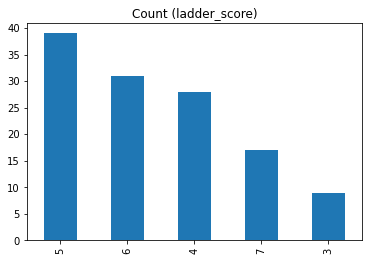

In [11]:
#graph count of unique ladder_scores
df2['ladder_score'].value_counts().plot(kind='bar', title='Count (ladder_score)');

In [12]:
# Create columns and target variables for SMOTEN
labels = [
        'ladder_score', 'healty_life_exp', 'covid_tests_per_mil', 'freedom', 'social_support', 'percept_corrupt', 
        'log_gdp_per_cap', 'covid_total_tests', 'meat_consumption', 'median_age', 'generosity', 'land_area_skm', 
        'covid_cases_per_mil'
    ]
columns = [
        'ladder_score', 'healty_life_exp', 'covid_tests_per_mil', 'freedom', 'social_support', 'percept_corrupt', 
        'log_gdp_per_cap', 'covid_total_tests', 'meat_consumption', 'median_age', 'generosity', 'land_area_skm', 
        'covid_cases_per_mil'
    ]

target = ["ladder_score"]
    



In [13]:
#function to run SMOTEN on lowests count and display
def SMOTE_func():   
    global df2
    smote = SMOTE(sampling_strategy='minority', n_jobs=-1)
    X_sm, y_sm = smote.fit_resample(df2[columns], df2['ladder_score'])

    df2 = pd.DataFrame(X_sm, columns=labels)
    df2['ladder_score'] = y_sm

    df2['ladder_score'].value_counts().plot(kind='bar', title='Count (ladder_score)');

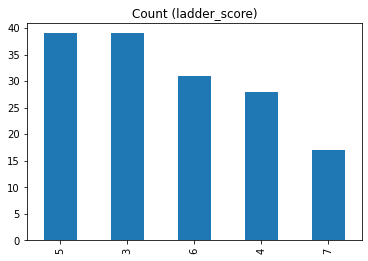

In [14]:
SMOTE_func()

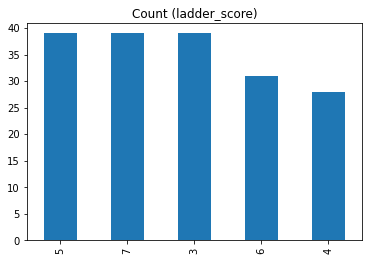

In [15]:
#rerun to balance out happiness score for new lowest count
SMOTE_func()

In [16]:
#View total count for each score
df2['ladder_score'].value_counts()

5    39
7    39
3    39
6    31
4    28
Name: ladder_score, dtype: int64

# Split and Scale data for training

In [17]:
# Define features set
X = df2.copy()
X = X.drop("ladder_score", axis=1)
X.head()

,healty_life_exp,covid_tests_per_mil,freedom,social_support,percept_corrupt,log_gdp_per_cap,covid_total_tests,meat_consumption,median_age,generosity,land_area_skm,covid_cases_per_mil
0,69.000,17564.0,0.828,0.898,0.834,9.962,794544.0,79.7,31.7,-0.182,2780400.0,5044.0
1,67.055,57898.0,0.825,0.799,0.629,9.487,171600.0,27.7,35.1,-0.168,29743.0,13435.0
2,73.900,181419.0,0.914,0.940,0.442,10.796,4631419.0,108.2,38.7,0.159,7741220.0,779.0
3,73.300,104008.0,0.908,0.934,0.481,10.906,937275.0,94.1,44.0,0.042,83871.0,2408.0
4,65.656,75499.0,0.814,0.836,0.506,9.569,766179.0,15.9,32.3,-0.223,86600.0,3276.0


In [18]:
# Define target vector
y = df2["ladder_score"].values.reshape(-1, 1)


In [19]:

# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78, train_size=0.80 )

# Creating StandardScaler instance
scaler = StandardScaler()
    
# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)


In [20]:
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Fitting the Decision Tree Model

In [21]:
def decision_tree_model():
    # Creating the decision tree classifier instance
    model = tree.DecisionTreeClassifier()
    # Fitting the model
    model = model.fit(X_train_scaled, y_train)
    # Making predictions using the testing data
    predictions = model.predict(X_test_scaled)
    # Calculating the confusion matrix
    cm = confusion_matrix(y_test, predictions)
    cm_df = pd.DataFrame(
    cm, index=["Actual 3", "Actual 4", "Actual 5", "Actual 6", "Actual 7"], 
    columns=["Predicted 3", "Predicted 4", "Predicted 5", "Predicted 6", "Predicted 7"]
    )
    sns.heatmap(cm_df, annot=True)

    # Calculating the accuracy score
    acc_score = accuracy_score(y_test, predictions)
    # Displaying results
    #display(cm_df)
    print(f"Accuracy Score : {acc_score}")
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print("Confusion Matrix")

Accuracy Score : 0.5833333333333334
Classification Report
              precision    recall  f1-score   support

           3       0.69      0.92      0.79        12
           4       0.33      0.22      0.27         9
           5       0.33      0.33      0.33         6
           6       0.80      0.57      0.67         7
           7       0.67      1.00      0.80         2

    accuracy                           0.58        36
   macro avg       0.56      0.61      0.57        36
weighted avg       0.56      0.58      0.56        36

Confusion Matrix


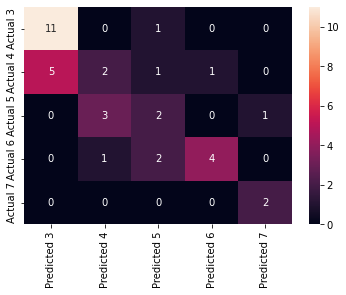

In [22]:
decision_tree_model()